# Intento de suicidio en Colombia (2016-2023):  Análisis de datos exploratorio 

En este documento se presenta un análisis exploratorio de ocho bases de datos relacionadas con los casos de suicidio en Colombia entre los años 2016 y 2023, reportados al Sistema Nacional de Vigilancia en Salud Pública (SIVIGILA). Previamente, se llevó a cabo una exhaustiva limpieza de datos y las bases han sido fusionadas en un archivo consolidado. Se excluyeron variables que no aportaban información relevante, como los códigos de eventos, las unidades de atención, y aquellas que contenían datos duplicados. El código en R utilizado para este análisis está disponible en este mismo repositorio.

In [55]:
import pandas as pd
import folium
from PIL import Image
from scipy.stats import shapiro
from scipy.stats import anderson
import matplotlib.pyplot as plt
from IPython.display import Image, display
import plotly.io as pio
import kaleido
import seaborn as sns
from folium import Choropleth, GeoJson, GeoJsonTooltip
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import seasonal
import geopandas as gpd
from shapely.validation import make_valid
import plotly.express as px
import numpy as np
from shapely.geometry import shape
from shapely.validation import make_valid
from shapely.ops import unary_union
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from statsmodels.tsa import stattools

In [56]:
df = pd.read_csv("C:/Users/jcami/OneDrive/Escritorio/Tablero_dataviz/Datos_356_2clean.csv",dtype={'nationality': str})
df = df.iloc[:, 1:]

El análisis preliminar de la base de datos muestra que contiene 26 variables y 237,685 observaciones.

In [57]:
df.shape

(237685, 27)

A continuación, se procederá a recodificar las variables dicotómicas presentes en la base de datos para facilitar su análisis posterior:

In [58]:
df['psychiatric'] = df['psychiatric'].map({0: 'No', 1: 'Sí'})
df['admission_h'] = df['admission_h'].map({0: 'No', 1: 'Sí'})
df['disability'] = df['disability'].map({0: 'No', 1: 'Sí'})
df['displaced'] = df['displaced'].map({0: 'No', 1: 'Sí'})
df['migrant'] = df['migrant'].map({0: 'No', 1: 'Sí'})
df['incarcerated'] = df['incarcerated'].map({0: 'No', 1: 'Sí'})
df['pregnant'] = df['pregnant'].map({0: 'No', 1: 'Sí'})
df['indigenous'] = df['indigenous'].map({0: 'No', 1: 'Sí'})
df['low_income'] = df['low_income'].map({0: 'No', 1: 'Sí'})
df['single_mother'] = df['single_mother'].map({0: 'No', 1: 'Sí'})
df['demobilized'] = df['demobilized'].map({0: 'No', 1: 'Sí'})
df['violence_victim'] = df['violence_victim'].map({0: 'No', 1: 'Sí'})

Para examinar los datos almacenados en cada variable y determinar la presencia de datos faltantes, se utiliza la función `describe()` en pandas:

In [60]:
df.describe(include='all')

,date,week,year,age,nationality,sex,area,occupation,ss_type,ethnicity,...,low_income,single_mother,demobilized,psychiatric,violence_victim,others,admission_h,date_h,department,occupation_reco
count,237685,237685.000000,237685.000000,237685.000000,160060,237685,237685,2.376850e+05,237685,237685,...,236550,237646,237618,231111,236790,237685.000000,237685,142774,237685,237685
unique,2992,NaN,NaN,NaN,55,2,3,NaN,5,6,...,1,1,1,1,1,NaN,2,3012,34,11
top,2023-10-23,NaN,NaN,NaN,colombia,femenino,urbano,NaN,subsidiado,otro,...,Sí,Sí,Sí,Sí,Sí,NaN,Sí,2023-03-06,antioquia,ocupación no registrada
freq,198,NaN,NaN,NaN,155873,151515,195315,NaN,114679,225548,...,236550,237646,237618,231111,236790,NaN,143101,116,38642,175651
mean,NaN,27.087759,2019.946753,25.305446,NaN,NaN,NaN,1.369493e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.937367,NaN,NaN,NaN,NaN
std,NaN,14.681744,2.265484,12.569272,NaN,NaN,NaN,3.423424e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.242303,NaN,NaN,NaN,NaN
min,NaN,1.000000,2016.000000,4.000000,NaN,NaN,NaN,1.100000e+02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,14.000000,2018.000000,16.000000,NaN,NaN,NaN,9.996000e+03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
50%,NaN,27.000000,2020.000000,21.000000,NaN,NaN,NaN,9.997000e+03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
75%,NaN,40.000000,2022.000000,30.000000,NaN,NaN,NaN,9.999000e+03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN


# Estudio de la varibales

En esta sección se llevará a cabo un análisis detallado de cada una de las variables presentes en la base de datos. En cada caso, se explicará el proceso seguido, justificando los pasos cuando sea necesario

## Sexo

Como su nombre lo indica, la variable `sex` contiene información sobre el sexo registrado en cada caso. El análisis previo realizado en R no reveló datos faltantes, por lo que no se realizaron modificaciones adicionales a esta variable. Por lo tanto, en esta sección nos limitaremos a construir una tabla de frecuencias para examinar la proporción de hombres y mujeres en la base de datos:

In [7]:
observaciones_sex = df.groupby('sex').size().reset_index(name='conteo')
observaciones_sex['Proporción'] = observaciones_sex['conteo'] / observaciones_sex['conteo'].sum()
observaciones_sex['Porcentaje'] = (observaciones_sex['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_sex)

         sex  conteo  Proporción Porcentaje
0   femenino  151515    0.637461     63.75%
1  masculino   86170    0.362539     36.25%


La tabla muestra que una gran proporción de los suicidios reportados en Colombia entre 2016 y 2023 corresponde a mujeres, representando aproximadamente el 64% de los casos registrados, mientras que los hombres constituyen el 36% restante. Con esto, se concluye el análisis de esta variable construyendo un diagrama circular que ayudará a visualizar la proporción de hombres y mujeres en la muestra.

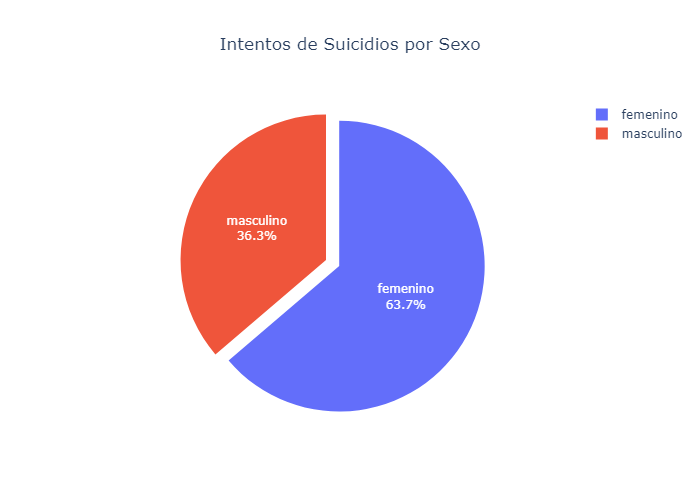

In [12]:
fig = px.pie(observaciones_sex,names='sex',values='conteo',title='Intentos de Suicidios por Sexo')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}')
fig.update_traces(textinfo='percent+label',textfont_color='white',hoverlabel=dict(font_color='white'))
fig.update_traces(pull=[0.1, 0])  # Para "separar" la primera porción
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Población psiquiátrica

La variable `psychiatric`  indica si la persona que intentó suicidarse estaba internada en una institución psiquiátrica. Al igual que en el caso anterior, el análisis previo realizado en R no reveló datos faltantes, por lo que no se realizaron modificaciones adicionales a esta variable. En consecuencia, se procederá a construir una tabla de frecuencias:

In [10]:
observaciones_psi = df.groupby('psychiatric').size().reset_index(name='conteo')
observaciones_psi['Proporción'] = observaciones_psi['conteo'] / observaciones_psi['conteo'].sum()
observaciones_psi['Porcentaje'] = (observaciones_psi['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_psi)

  psychiatric  conteo  Proporción Porcentaje
0          No  231111    0.972342     97.23%
1          Sí    6574    0.027658      2.77%


La tabla muestra que solo una pequeña proporción de los casos de intento de suicidio correspondía a personas internadas en instituciones de salud mental, representando aproximadamente el 3% del total de casos reportados. A continuación, se procederá a construir un gráfico circular:

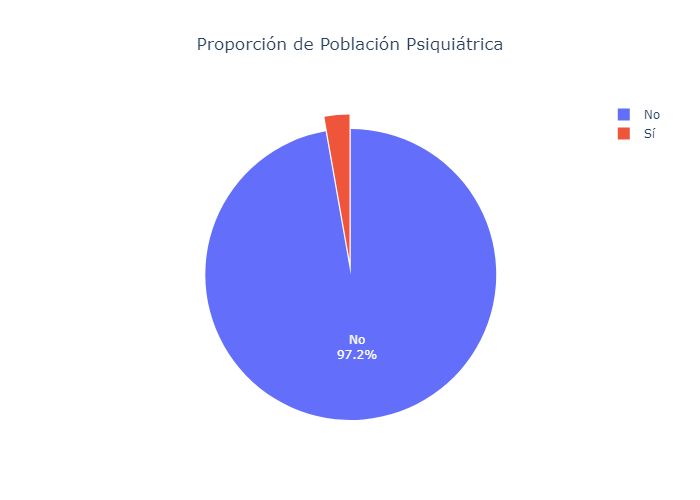

In [11]:
fig = px.pie(observaciones_psi,names='psychiatric', values='conteo',title='Proporción de Población Psiquiátrica')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Población con discapacidades

La variable `disability`  indica si la persona que intentó suicidarse presentaba alguna discapacidad. Al igual que en el caso anterior, el análisis previo realizado en R no reveló datos faltantes, por lo que no se realizaron modificaciones adicionales a esta variable. En consecuencia, se procederá a construir una tabla de frecuencias:

In [13]:
observaciones_disa = df.groupby('disability').size().reset_index(name='conteo')
observaciones_disa['Proporción'] = observaciones_disa['conteo'] / observaciones_disa['conteo'].sum()
observaciones_disa['Porcentaje'] = (observaciones_disa['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_disa)

  disability  conteo  Proporción Porcentaje
0         No  236928    0.996815     99.68%
1         Sí     757    0.003185      0.32%


La tabla de frecuencias revela que casi la totalidad de los suicidios en Colombia entre 2016 y 2023 ocurrieron en personas sin discapacidad, representando aproximadamente el 99.7% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de personas con discapacidad dentro de la muestra.

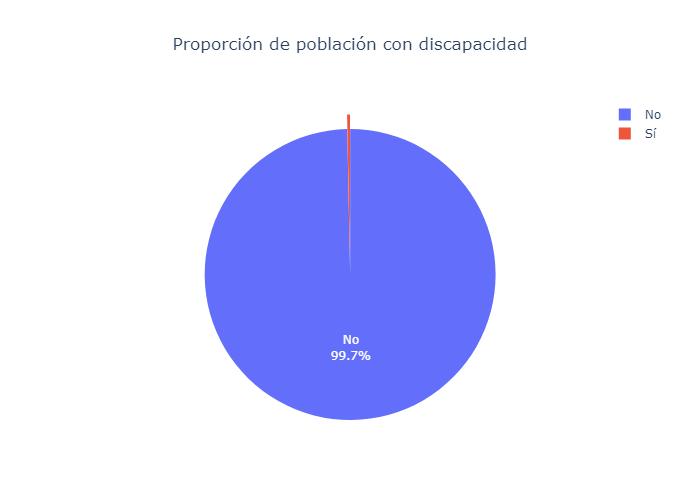

In [14]:
fig = px.pie(observaciones_disa,names='disability', values='conteo',title='Proporción de población con discapacidad')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Población desplazada

La variable `displaced` indica si la persona que intentó suicidarse había siedo desplazada. Al igual que en el caso anterior, el análisis previo realizado en R no reveló datos faltantes, por lo que no se realizaron modificaciones adicionales a esta variable. En consecuencia, se procederá a construir una tabla de frecuencias:

In [15]:
observaciones_disp = df.groupby('displaced').size().reset_index(name='conteo')
observaciones_disp['Proporción'] = observaciones_disp['conteo'] / observaciones_disp['conteo'].sum()
observaciones_disp['Porcentaje'] = (observaciones_disp['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_disp)

  displaced  conteo  Proporción Porcentaje
0        No  236395    0.994573     99.46%
1        Sí    1290    0.005427      0.54%


Tal como en el caso anterior, la tabla de frecuencias revela que casi la totalidad de los suicidios en Colombia entre 2016 y 2023 ocurrieron en personas que no eran desplazadas, representando aproximadamente el 99.5% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de personas con desplazadas dentro de la muestra.

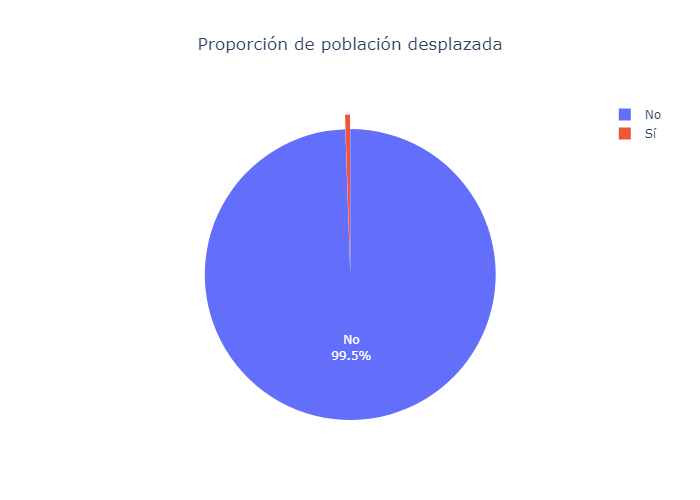

In [16]:
fig = px.pie(observaciones_disp,names='displaced', values='conteo',title='Proporción de población desplazada')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Población migrante

La variable `migrant` indica si la persona que intentó suicidarse habia migrado al país. Al igual que en el caso anterior, el análisis previo realizado en R no reveló datos faltantes, por lo que no se realizaron modificaciones adicionales a esta variable. En consecuencia, se procederá a construir una tabla de frecuencias:

In [17]:
observaciones_migr = df.groupby('migrant').size().reset_index(name='conteo')
observaciones_migr['Proporción'] = observaciones_migr['conteo'] / observaciones_migr['conteo'].sum()
observaciones_migr['Porcentaje'] = (observaciones_migr['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_migr)

  migrant  conteo  Proporción Porcentaje
0      No  234953    0.988506     98.85%
1      Sí    2732    0.011494      1.15%


La tabla de frecuencias indica que casi la totalidad de los suicidios en Colombia entre 2016 y 2023 ocurrieron en personas que no eran migrantes, representando aproximadamente el 98.8% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de población migrante en la muestra:

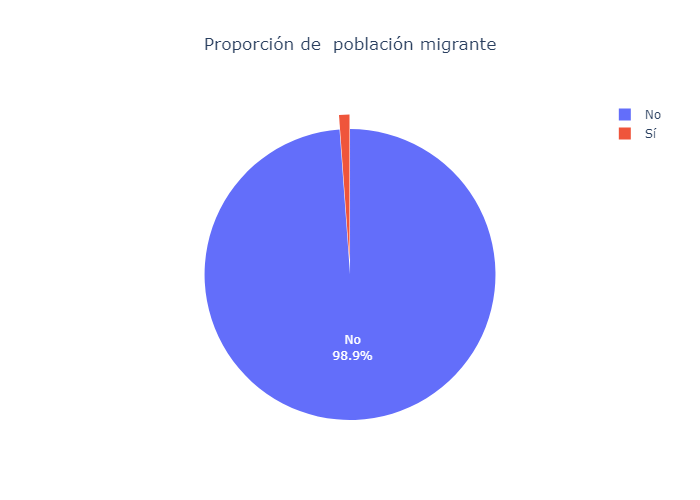

In [18]:
fig = px.pie(observaciones_migr,names='migrant', values='conteo',title='Proporción de  población migrante')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Población carcelaria

La variable `incarcerated` indica si la persona que intentó suicidarse estaba recluida en un centro penitenciario al momento del suceso. Al igual que en el caso anterior, el análisis previo realizado en R no reveló datos faltantes, por lo que no se realizaron modificaciones adicionales a esta variable. En consecuencia, se procederá a construir una tabla de frecuencias:

In [19]:
observaciones_carce = df.groupby('incarcerated').size().reset_index(name='conteo')
observaciones_carce['Proporción'] = observaciones_carce['conteo'] / observaciones_carce['conteo'].sum()
observaciones_carce['Porcentaje'] = (observaciones_carce['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_carce)

  incarcerated  conteo  Proporción Porcentaje
0           No  234216    0.985405     98.54%
1           Sí    3469    0.014595      1.46%


La tabla de frecuencias indica que casi la totalidad de los suicidios en Colombia ocurrieron en personas que no estaban recluidas en un centro penitenciario, representando aproximadamente el 98.5% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de la población carcelaria de la muestra:

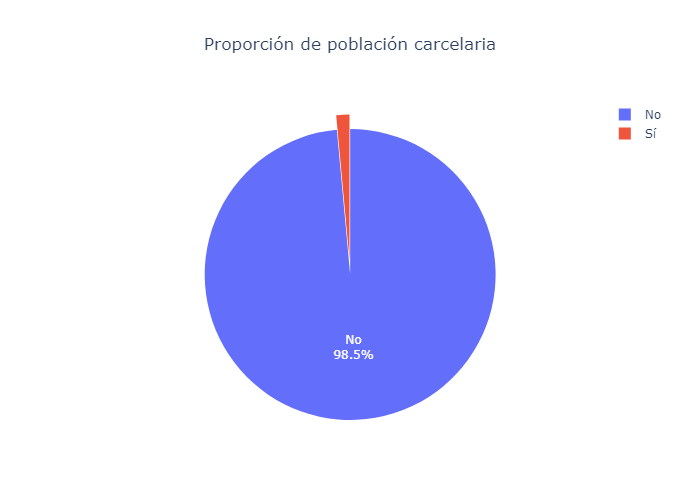

In [20]:
fig = px.pie(observaciones_carce,names='incarcerated', values='conteo',title='Proporción de población carcelaria')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Población indígena

La variable `indigenous` señala si la persona que intentó suicidarse pertenecía a alguno de los grupos indígenas presentes en el territorio colombiano. Al igual que en el análisis anterior, no se detectaron datos faltantes tras el procesamiento en R, por lo que no fue necesario realizar modificaciones adicionales a esta variable. A continuación, se procederá a construir una tabla de frecuencias:

In [21]:
observaciones_indi = df.groupby('indigenous').size().reset_index(name='conteo')
observaciones_indi['Proporción'] = observaciones_indi['conteo'] / observaciones_indi['conteo'].sum()
observaciones_indi['Porcentaje'] = (observaciones_indi['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_indi)

  indigenous  conteo  Proporción Porcentaje
0         No  236393    0.994564     99.46%
1         Sí    1292    0.005436      0.54%


La tabla de frecuencias muestra que solo una pequeña fracción de los intentos de suicidio reportados entre 2016 y 2023 ocurrió en población indígena, representando aproximadamente el 0.54% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de población indígena en la muestra:

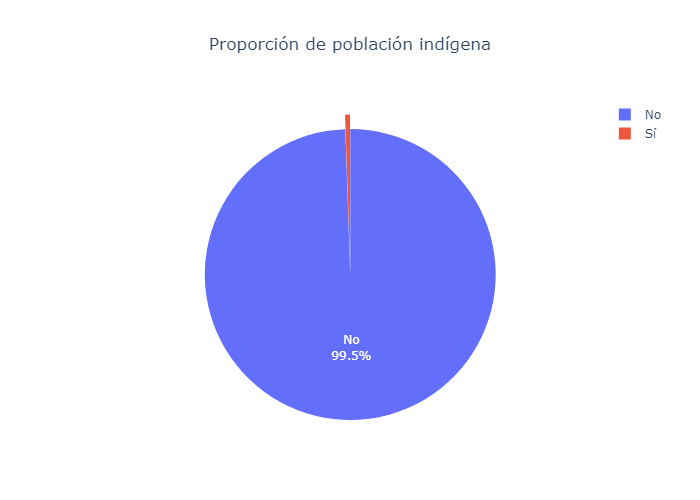

In [22]:
fig = px.pie(observaciones_indi,names='indigenous', values='conteo',title='Proporción de población indígena')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Población embarazada

La variable `pregnant` indica si la persona que intentó suicidarse estaba embarazada. Al igual que en los análisis previos, no se detectaron datos faltantes en esta variable tras el procesamiento en R, por lo que no fue necesario realizar modificaciones adicionales. A continuación, se procederá a construir una tabla de frecuencias para analizar la distribución de los datos:

In [23]:
observaciones_emba = df.groupby('pregnant').size().reset_index(name='conteo')
observaciones_emba['Proporción'] = observaciones_emba['conteo'] / observaciones_emba['conteo'].sum()
observaciones_emba['Porcentaje'] = (observaciones_emba['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_emba)

  pregnant  conteo  Proporción Porcentaje
0       No  235708    0.991682     99.17%
1       Sí    1977    0.008318      0.83%


La tabla de frecuencias muestra que solo una pequeña fracción de los intentos de suicidio reportados ocurrió en población embarazada, representando aproximadamente el 0.83% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de población embarazada en la muestra:

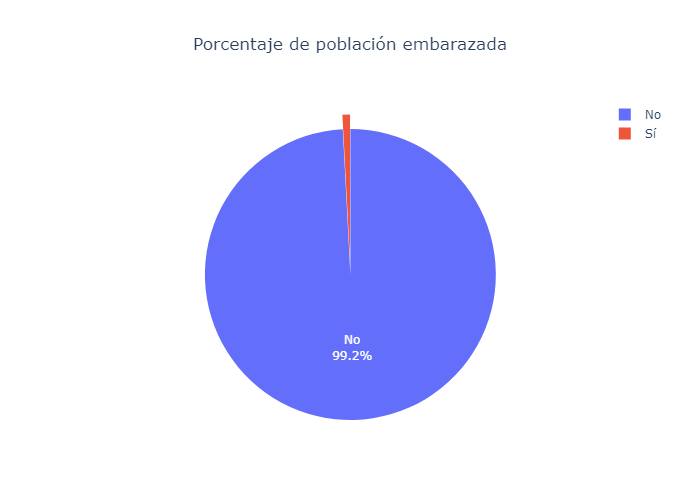

In [24]:
fig = px.pie(observaciones_emba,names='pregnant', values='conteo',title='Porcentaje de población embarazada')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

Dado que esta variable está intrínsecamente relacionada con el sexo de las personas, se procederá a construir una tabla de contingencia para examinar la relación entre el estado de embarazo y el sexo de las personas que intentaron suicidarse. Esta tabla permitirá evaluar cómo se distribuyen los casos de intento de suicidio entre las personas embarazadas en función de su sexo, proporcionando una visión más detallada sobre esta asociación:

In [62]:
pd.crosstab(df['pregnant'], df['sex'])

sex,femenino,masculino
pregnant,,
No,149538,86170
Sí,1977,0


Como era de esperar, todos los casos de embarazo se registraron en la población femenina. Por lo tanto, se procederá a construir una tabla de frecuencias restringida exclusivamente a la población femenina, para analizar detalladamente los casos de intento de suicidio entre las mujeres embarazadas:

In [25]:
observaciones_emba = df[df['sex'] == 'femenino'].groupby('pregnant').size().reset_index(name='conteo')
observaciones_emba['Proporción'] = observaciones_emba['conteo'] / observaciones_emba['conteo'].sum()
observaciones_emba['Porcentaje'] = (observaciones_emba['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_emba)

  pregnant  conteo  Proporción Porcentaje
0       No  149538    0.986952      98.7%
1       Sí    1977    0.013048       1.3%


De manera similar al caso anterior, la tabla de frecuencias revela que solo una pequeña fracción de los intentos de suicidio reportados en mujeres correspondió a población embarazada, representando aproximadamente el 1.3% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de mujeres embarazadas en la muestra:

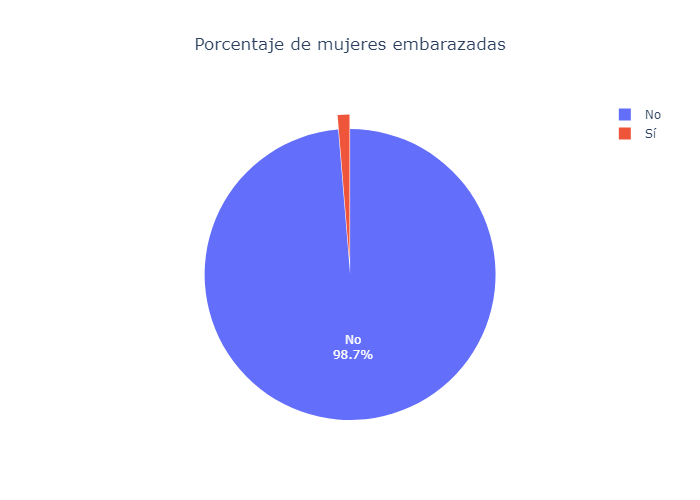

In [27]:
fig = px.pie(observaciones_emba,names='pregnant', values='conteo',title='Porcentaje de mujeres embarazadas')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Madres solteras

La variable `single_mother` indica si la persona que intentó suicidarse era una madre/padre soltera/o. Al igual que en los análisis previos, no se detectaron datos faltantes en esta variable tras el procesamiento en R, por lo que no fue necesario realizar modificaciones adicionales. A continuación, se procederá a construir una tabla de frecuencias para analizar la distribución de los datos:

In [28]:
observaciones_sol = df.groupby('single_mother').size().reset_index(name='conteo')
observaciones_sol['Proporción'] = observaciones_sol['conteo'] / observaciones_sol['conteo'].sum()
observaciones_sol['Porcentaje'] = (observaciones_sol['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_sol)

  single_mother  conteo  Proporción Porcentaje
0            No  237646    0.999836     99.98%
1            Sí      39    0.000164      0.02%


La tabla de frecuencias muestra que solo una pequeña fracción de los intentos de suicidio reportados ocurrió en madres solteras representando aproximadamente el 0.02% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de población embarazada en la muestra:

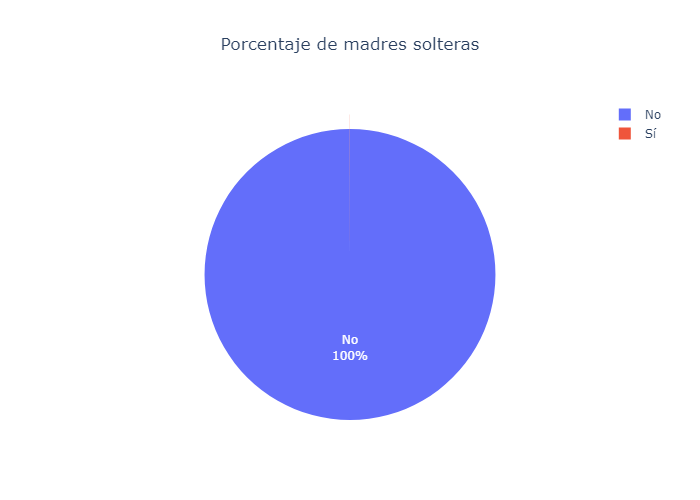

In [29]:
fig = px.pie(observaciones_sol,names='single_mother', values='conteo',title='Porcentaje de madres solteras')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

Tal como en el caso anterior, esta varibale esta instrinsicamente relacianda con el sexo de las personas. Por lo cual, se procedere a construir una tabla de contingencia entre las varibales de `single_mother` y `sex`:

In [77]:
pd.crosstab(df['single_mother'], df['sex'])

sex,femenino,masculino
single_mother,,
No,151479,86167
Sí,36,3


En este caso, se observa la presencia de padres y madres solteros entre los casos de intento de suicidio. Por lo tanto, se procederá a construir dos tablas de frecuencias, una para cada sexo, para analizar la distribución de estos casos en función del estado civil de los padres

In [30]:
obs_sol_M = df[df['sex'] == 'femenino'].groupby('single_mother').size().reset_index(name='conteo')
obs_sol_M ['Proporción'] = obs_sol_M ['conteo'] / obs_sol_M ['conteo'].sum()
obs_sol_M ['Porcentaje'] = (obs_sol_M ['Proporción'] * 100).round(2).astype(str) + '%'
print(obs_sol_M)

  single_mother  conteo  Proporción Porcentaje
0            No  151479    0.999762     99.98%
1            Sí      36    0.000238      0.02%


In [31]:
obs_sol_H = df[df['sex'] == 'masculino'].groupby('single_mother').size().reset_index(name='conteo')
obs_sol_H ['Proporción'] = obs_sol_H ['conteo'] / obs_sol_H ['conteo'].sum()
obs_sol_H ['Porcentaje'] = (obs_sol_H ['Proporción'] * 100).round(2).astype(str) + '%'
print(obs_sol_H)

  single_mother  conteo  Proporción Porcentaje
0            No   86167    0.999965     100.0%
1            Sí       3    0.000035       0.0%


Es evidente que, en ambos sexos, solo una pequeña proporción de los casos se refiere a padres o madres solteros. Por lo tanto, se concluye el análisis de esta variable.

## Población desmobilizada

La variable `demobilized` señala si la persona que intentó suicidarse pertenecía a población desmobilizada. No se detectaron datos faltantes tras el procesamiento en R, por lo que no fue necesario realizar modificaciones adicionales a esta variable. A continuación, se procederá a construir una tabla de frecuencias:

In [32]:
observaciones_dem = df.groupby('demobilized').size().reset_index(name='conteo')
observaciones_dem['Proporción'] = observaciones_dem['conteo'] / observaciones_dem['conteo'].sum()
observaciones_dem['Porcentaje'] = (observaciones_dem['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_dem)

  demobilized  conteo  Proporción Porcentaje
0          No  237618    0.999718     99.97%
1          Sí      67    0.000282      0.03%


La tabla de frecuencias muestra que solo una pequeña fracción de los intentos de suicidio reportados entre 2016 y 2023 ocurrió en población desmobilizada, representando aproximadamente el 0.03% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de población desmobilizada en la muestra:

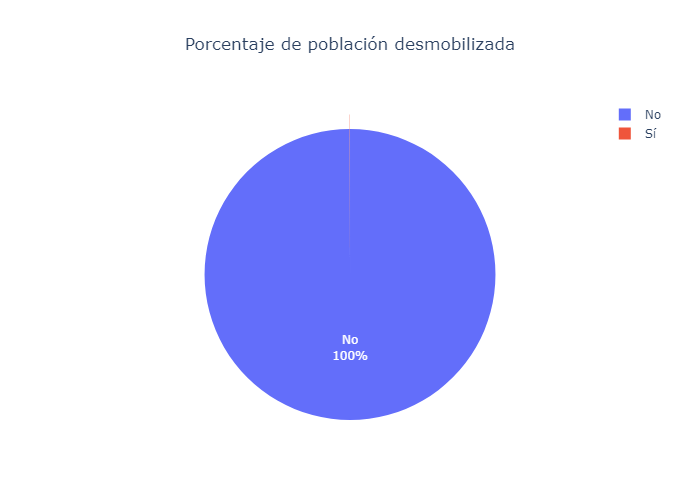

In [33]:
fig = px.pie(observaciones_dem,names='demobilized', values='conteo',title='Porcentaje de población desmobilizada')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Población victima de violencia

Tal como su nombre los indica, la variable `violence_victim`  contiene información que permite identificar si la persona que intentó quitarse la vida fue presuntamente víctima de violencia. No se detectaron datos faltantes tras el procesamiento en R, por lo que no fue necesario realizar modificaciones adicionales a esta variable. A continuación, se presenta una tabla de frecuencias:

In [34]:
observaciones_vio = df.groupby('violence_victim').size().reset_index(name='conteo')
observaciones_vio['Proporción'] = observaciones_vio['conteo'] / observaciones_vio['conteo'].sum()
observaciones_vio['Porcentaje'] = (observaciones_vio['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_vio)

  violence_victim  conteo  Proporción Porcentaje
0              No  236790    0.996235     99.62%
1              Sí     895    0.003765      0.38%


La tabla de frecuencias muestra que solo una pequeña fracción de los intentos de suicidio reportados entre 2016 y 2023 ocurrió en población victima de violencia, representando aproximadamente el 0.38% del total de casos. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de población victima de violencia en la muestra:

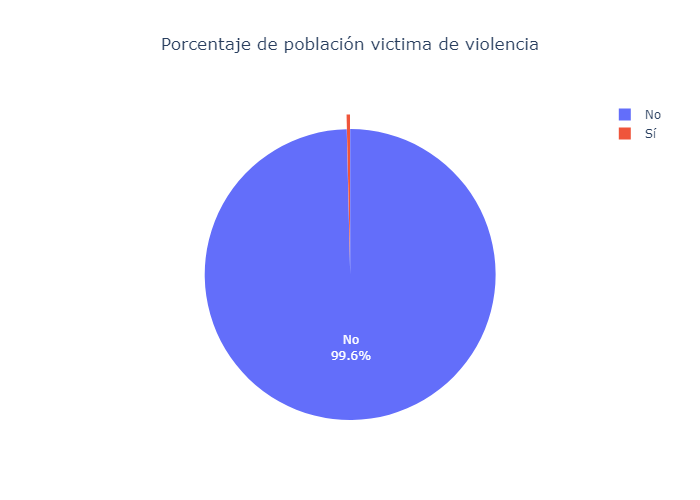

In [35]:
fig = px.pie(observaciones_vio,names='violence_victim', values='conteo',title='Porcentaje de población victima de violencia')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Régimen de salud

La variable `ss_type` roporciona información sobre el régimen de salud al que estaban afiliadas las personas que intentaron suicidarse en Colombia. Dado que en las bases originales del SIVIGILA esta variable se codifica mediante iniciales, se realizó una recodificación utilizando la información proporcionada en el informe técnico sobre los intentos de suicidio. Además, no se detectaron datos faltantes tras el procesamiento en R. A continuación, se presenta una tabla de frecuencias:

In [36]:
df['ss_type'] = df['ss_type'].replace('inderminadopendiente', 'Indeterminado')
observaciones_ss_type = df.groupby('ss_type').size().reset_index(name='conteo')
total = observaciones_ss_type['conteo'].sum()
observaciones_ss_type['proporción'] = observaciones_ss_type['conteo'] / total
observaciones_ss_type['porcentaje'] = (observaciones_ss_type['proporción']) * 100
observaciones_ss_type = observaciones_ss_type.sort_values(by='conteo', ascending=False)
observaciones_ss_type

,ss_type,conteo,proporción,porcentaje
4,subsidiado,114679,0.482483,48.248312
1,contributivo,101756,0.428113,42.811284
3,no asegurado,9177,0.038610,3.860992
2,excepción,7133,0.030010,3.001031
0,Indeterminado,4940,0.020784,2.078381


La tabla de frecuencias revela que la mayoría de las personas asociadas a los casos de suicidio en Colombia entre 2016 y 2023 estaban afiliadas al régimen subsidiado o al régimen contributivo, representando aproximadamente el 48.2% y el 42.8% del total de casos, respectivamente. A continuación, se presenta un gráfico de barras que facilita la visualización de la distribución del régimen de salud en la muestra:

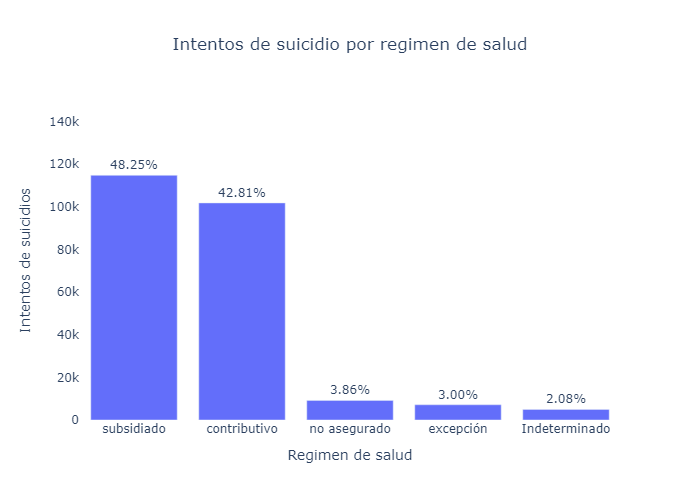

In [37]:
fig = px.bar(observaciones_ss_type, x='ss_type', y='conteo',
    title='Intentos de suicidio por regimen de salud',
    labels={'ss_type': 'Regimen de salud', 'conteo': 'Intentos de suicidios'})
fig.update_traces(
    text=observaciones_ss_type['porcentaje'].map('{:.2f}%'.format), textposition='outside')
fig.update_layout(title_x=0.5)
fig.update_layout(title_x=0.5, yaxis=dict(range=[0, 150000]), paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Área

La variable `area` proporciona información sobre el lugar donde ocurrieron o se reportaron los intentos de suicidio. Al igual que en el caso anterior, en las bases originales del SIVIGILA, esta variable se codifica mediante números del 1 al 3. Por lo tanto, se realizó una recodificación utilizando la información proporcionada en el informe técnico sobre los intentos de suicidio. Además, no se detectaron datos faltantes tras el procesamiento en R. A continuación, se presenta una tabla de frecuencias:

In [38]:
observaciones_area = df.groupby('area').size().reset_index(name='conteo')
total = observaciones_area['conteo'].sum()
observaciones_area['proporción'] = observaciones_area['conteo'] / total
observaciones_area['porcentaje'] = observaciones_area['proporción'] * 100
observaciones_area = observaciones_area.sort_values(by='conteo', ascending=False)
print(observaciones_area)

                 area  conteo  proporción  porcentaje
2              urbano  195315    0.821739   82.173886
0  cabecera municipal   26496    0.111475   11.147527
1               rural   15874    0.066786    6.678587


La tabla de frecuencias muestra que una gran proporción de los intentos de suicidio reportados ocurrió en áreas urbanas (82.2%), seguidos por las cabeceras municipales (11.1%) y, finalmente, en áreas rurales (6.7%). A continuación, se presenta un gráfico de barras que facilita la visualización de la distribución del área de ocurrencia en la muestra:

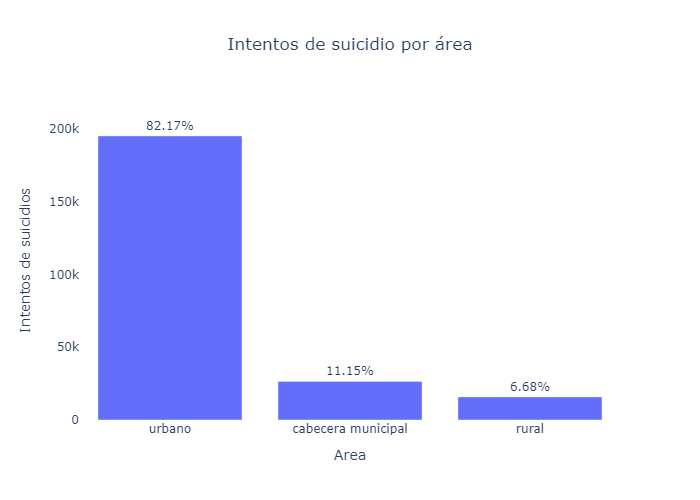

In [39]:
fig = px.bar(observaciones_area, x='area', y='conteo',
    title='Intentos de suicidio por área',
    labels={'area': 'Area', 'conteo': 'Intentos de suicidios'})

fig.update_traces(
    text=observaciones_area['porcentaje'].map('{:.2f}%'.format), textposition='outside')

fig.update_layout(title_x=0.5)
fig.update_layout(
    title_x=0.5, yaxis=dict(range=[0, 220000]),  paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Hospitalización

La variable `admission_h` indica si la persona que intentó quitarse la vida fue admitida a un centro de atención en salud después de reportado el suceso. No se detectaron datos faltantes tras el procesamiento en R, por lo que no fue necesario realizar modificaciones adicionales a esta variable. A continuación, se presenta una tabla de frecuencias:

In [40]:
observaciones_hos = df.groupby('admission_h').size().reset_index(name='conteo')
observaciones_hos['Proporción'] = observaciones_hos['conteo'] / observaciones_hos['conteo'].sum()
observaciones_hos['Porcentaje'] = (observaciones_hos['Proporción'] * 100).round(2).astype(str) + '%'
print(observaciones_hos)

  admission_h  conteo  Proporción Porcentaje
0          No   94584    0.397938     39.79%
1          Sí  143101    0.602062     60.21%


La tabla de frecuencias muestra que más de la mitad (aproximadamente el 60%) de los intentos de suicidio reportados en Colombia entre 2016 y 2023 resultaron en la admisión de las personas involucradas a un centro de atención en salud. A continuación, se presenta un gráfico circular que facilita la visualización de la proporción de personas hospitalizadas en la muestra:

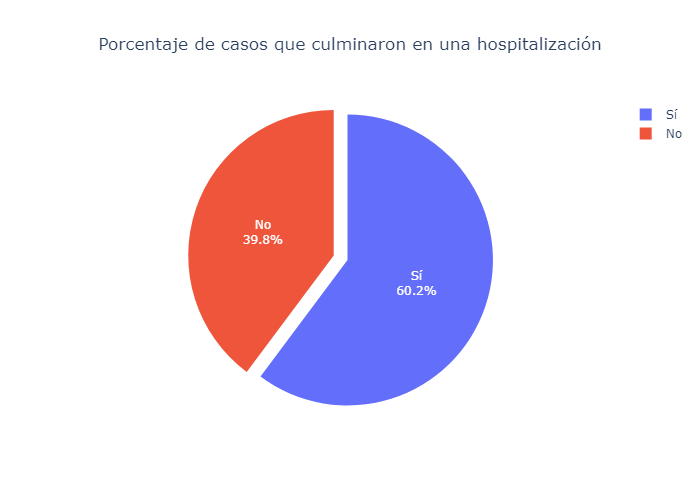

In [41]:
fig = px.pie(observaciones_hos,names='admission_h', values='conteo',title='Porcentaje de casos que culminaron en una hospitalización')
fig.update_traces(hovertemplate='%{percent} del total<br>Conteo: %{value}',textinfo='percent+label',textfont_color='white',
                  hoverlabel=dict(font_color='white'), pull=[0.1, 0])
fig.update_layout(title_x=0.5)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Estrato socioeconómico

La variable `ss_type` proporciona información sobre el régimen de salud al que estaban afiliadas las personas que intentaron suicidarse en Colombia. A diferencia de las variables analizadas anteriormente, el análisis previo realizado en R mostró una cantidad considerable de datos faltantes en esta variable. Por lo tanto, iniciaremos su análisis determinando el número exacto de datos faltantes:

In [40]:
df['ses'].isna().sum()

np.int64(109795)

Se observa que 109,795 observaciones (aproximadamente el 46.2% del total de casos) no contenían información sobre el estrato socioeconómico de las personas que intentaron suicidarse entre 2016 y 2023. Debido a la naturaleza de los datos y su relevancia para el análisis actual, no se considera conveniente realizar una imputación. Por lo tanto, procederemos con la descripción de los datos disponibles:

In [42]:
observaciones_ses = df.groupby('ses').size().reset_index(name='conteo')
total = observaciones_ses['conteo'].sum()
observaciones_ses['proporción'] = observaciones_ses['conteo'] / total
observaciones_ses['porcentaje'] = (observaciones_ses['proporción']) * 100
print(observaciones_ses)

   ses  conteo  proporción  porcentaje
0  1.0   47464    0.371131   37.113144
1  2.0   54220    0.423958   42.395809
2  3.0   21514    0.168223   16.822269
3  4.0    3246    0.025381    2.538119
4  5.0     889    0.006951    0.695129
5  6.0     557    0.004355    0.435531


La tabla de frecuencias revela que una gran parte de los intentos de suicidio reportados en el país entre 2016 y 2023 corresponde a personas de estrato uno y dos, representando aproximadamente el 37.1% y el 42.4% del total de casos, respectivamente. A continuación, se presenta un gráfico de barras que facilita la visualización de la distribución del estrato socioeconómico en la muestra:

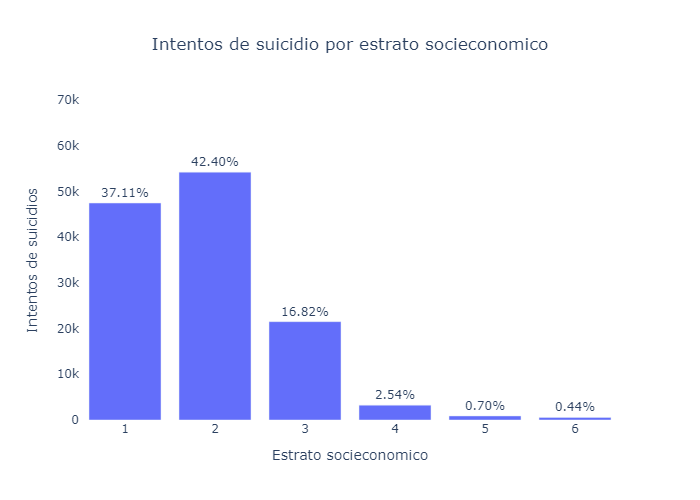

In [43]:
fig = px.bar(observaciones_ses, x='ses', y='conteo',
    title='Intentos de suicidio por estrato socieconomico',
    labels={'ses': 'Estrato socieconomico', 'conteo': 'Intentos de suicidios'})

fig.update_traces(
    text=observaciones_ses['porcentaje'].map('{:.2f}%'.format), textposition='outside')

fig.update_layout(title_x=0.5)
fig.update_layout(
    title_x=0.5, yaxis=dict(range=[0, 70000]),  paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Departamento

La variable `department` proporciona información sobre el departamento en el que ocurrió el intento de suicidio. En las bases de datos originales del SIVIGILA se reporta tanto el departamento de ocurrencia como el departamento de notificación del suceso. En muchos casos, la información proporcionada por ambas variables es la misma; sin embargo, también existen casos en los que el departamento de ocurrencia difiere del departamento de notificación. Para los propósitos de este análisis, solo se considerará el departamento de ocurrencia. No se detectaron datos faltantes tras el procesamiento en R, por lo que no fue necesario realizar modificaciones adicionales a esta variable. A continuación, se presenta una tabla de frecuencias:

In [44]:
observaciones_dpto = df.groupby('department').size().reset_index(name='conteo')
total = observaciones_dpto['conteo'].sum()
observaciones_dpto['proporción'] = observaciones_dpto['conteo'] / total
observaciones_dpto['porcentaje'] = (observaciones_dpto['proporción']) * 100
observaciones_dpto = observaciones_dpto.sort_values(by='conteo', ascending=False)
observaciones_dpto = observaciones_dpto[observaciones_dpto['department'] != 'procedencia desconocida']
observaciones_dpto = observaciones_dpto.head(10)
print(observaciones_dpto)

      department  conteo  proporción  porcentaje
1      antioquia   38642    0.162577   16.257652
4         bogota   29154    0.122658   12.265814
31         valle   22050    0.092770    9.276984
14  cundinamarca   14209    0.059781    5.978080
3      atlantico   12147    0.051105    5.110545
21        narino   10167    0.042775    4.277510
28     santander    9664    0.040659    4.065886
30        tolima    8943    0.037625    3.762543
7         caldas    8530    0.035888    3.588783
26     risaralda    7831    0.032947    3.294697


La tabla de frecuencias muestra que los departamentos del interior del país, en particular Antioquia (16.2%), Bogotá (12.3%) y Valle del Cauca (9.3%), reportaron el mayor número de casos de intentos de suicidio durante el período 2016-2023. Otros departamentos, como Atlántico (5.1%), Santander (4.1%) y Nariño (4.3%), también figuran entre los diez primeros en cuanto al número de casos en este período. A continuación, se presenta un diagrama de barras que facilita la visualización de la distribución de los casos de intentos de suicidio por departamento:

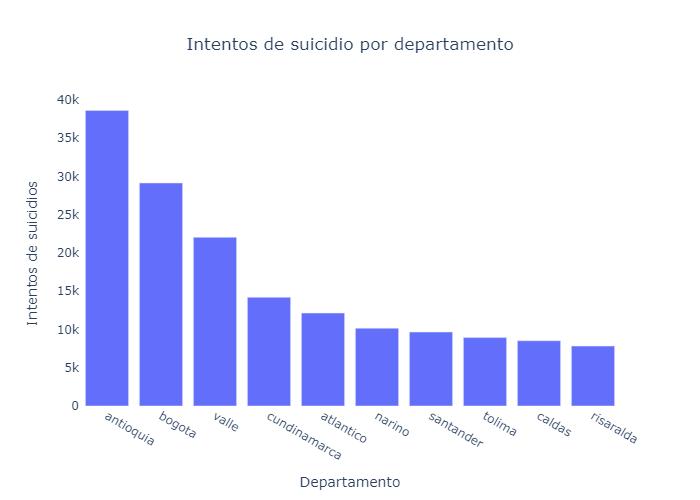

In [45]:
fig = px.bar(
    observaciones_dpto, 
    x='department', 
    y='conteo',
    title='Intentos de suicidio por departamento',
    labels={'department': 'Departamento', 'conteo': 'Intentos de suicidios'}
)

fig.update_traces(
    hovertemplate='%{x}: %{y}<br>Porcentaje: %{customdata:.2f}%<extra></extra>',
    customdata=observaciones_dpto[['porcentaje']]
)

fig.update_layout(
    title_x=0.5,
    yaxis=dict(range=[0, 40000]),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Nacionalidad

Tal como su nombre lo indica, la variable `nationality` e suicidio. Al igual que en un caso anterior, el análisis previo realizado en R mostró una cantidad considerable de datos faltantes en esta variable. Por lo tanto, iniciaremos el análisis determinando el número exacto de datos faltantes:

In [55]:
df['nationality'].isna().sum()

np.int64(77625)

Se observa que 77,625 observaciones (aproximadamente el 32.66% del total de casos) no contenían información sobre el estrato socioeconómico de las personas que intentaron suicidarse entre 2016 y 2023. Dado que la naturaleza de los datos y su relevancia para el análisis actual no justifican la imputación, procederemos a describir los datos disponibles:

In [46]:
observaciones_nacio = df.groupby('nationality').size().reset_index(name='conteo')
total = observaciones_nacio['conteo'].sum()
observaciones_nacio['proporción'] = observaciones_nacio['conteo'] / total
observaciones_nacio['porcentaje'] = observaciones_nacio['proporción'] * 100
observaciones_nacio = observaciones_nacio.sort_values(by='conteo', ascending=False)
observaciones_nacio = observaciones_nacio.head()
print(observaciones_nacio)

    nationality  conteo  proporción  porcentaje
15     colombia  155873    0.973841   97.384106
54    venezuela    3571    0.022310    2.231038
20  desconocida     425    0.002655    0.265525
52          usa      26    0.000162    0.016244
21      ecuador      25    0.000156    0.015619


La tabla de frecuencias muestra que casi la totalidad de los casos de intento de suicidio provenían de ciudadanos colombianos, representando aproximadamente el 97.4% del total de casos reportados. En segundo lugar se encuentra la nacionalidad venezolana, con un 2.23% del total de casos. A continuación, se presenta un diagrama que ilustra el porcentaje de las cinco nacionalidades más frecuentes en la muestra:

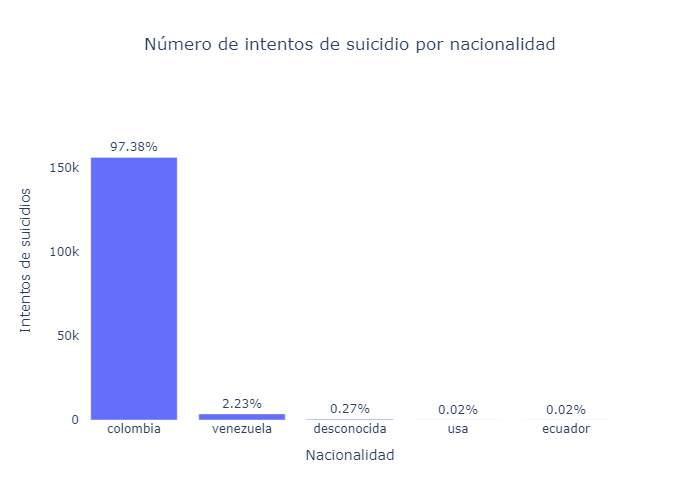

In [47]:
fig = px.bar(observaciones_nacio, x='nationality', y='conteo',
    title='Número de intentos de suicidio por nacionalidad',
    labels={'nationality': 'Nacionalidad', 'conteo': 'Intentos de suicidios'})

fig.update_traces(
    text=observaciones_nacio['porcentaje'].map('{:.2f}%'.format), textposition='outside')

fig.update_layout(title_x=0.5)
fig.update_layout(
    title_x=0.5, yaxis=dict(range=[0, 190000]),  paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

## Ocupación

La variable `occupation_reco` proporciona información sobre la ocupación de las personas que intentaron quitarse la vida en Colombia entre 2016 y 2023. En las bases de datos originales del SIVIGILA, la ocupación se clasifica según las categorías de la Clasificación Única de Ocupaciones para Colombia (CUOC). Para el análisis, se ha considerado únicamente la categoría más amplia, que corresponde al primer dígito del código de ocupación. No se detectaron datos faltantes durante el procesamiento en R, por lo que no fue necesario realizar modificaciones adicionales a esta variable. A continuación, se presenta una tabla de frecuencias que muestra la distribución de ocupaciones en la muestra.

In [63]:
observaciones_ocu = df.groupby('occupation_reco').size().reset_index(name='conteo')
total = observaciones_ocu['conteo'].sum()
observaciones_ocu['proporción'] = observaciones_ocu['conteo'] / total
observaciones_ocu['porcentaje'] = observaciones_ocu['proporción'] * 100
observaciones_ocu = observaciones_ocu.sort_values(by='conteo', ascending=False)
observaciones_ocu = observaciones_ocu
print(observaciones_ocu)

                 occupation_reco  conteo  proporción  porcentaje
6        ocupación no registrada  175651    0.739008   73.900751
5        ocupaciones elementales   23368    0.098315    9.831500
10     vendedores y comerciantes   12168    0.051194    5.119381
0   agricultores y agropecuarios    8126    0.034188    3.418811
8    profesionales y científicos    4586    0.019294    1.929444
7          operarios y artesanos    3858    0.016232    1.623157
9          técnicos y tecnologos    3546    0.014919    1.491891
1           apoyo administrativo    3187    0.013409    1.340850
4    máquinistas y ensambladores    1903    0.008006    0.800640
2          directores y gerentes     716    0.003012    0.301239
3              fuerzas militares     576    0.002423    0.242338


La tabla de frecuencias revela que aproximadamente el 74% de los casos de intento de suicidio están asociados a ocupaciones no registradas en la CUOC. Dado que la mayoría de los casos no tienen una ocupación específica en la CUOC, el análisis de esta variable se concluye sin incluir un diagrama para su visualización.

## Año

Como su nombre indica, la variable `year` contiene información sobre el año en que se reportó cada caso de intento de suicidio. Siguiendo el procedimiento aplicado a otras variables, se construye una tabla de frecuencias para analizar el porcentaje de casos por año. Posteriormente, se elabora un diagrama de barras para visualizar la distribución de los datos.

In [48]:
observaciones_year = df.groupby('year').size().reset_index(name='conteo')
total = observaciones_year['conteo'].sum()
observaciones_year['porcentaje'] = (observaciones_year['conteo'] / total) * 100
observaciones_year['year'] = observaciones_year['year'].astype('category')
observaciones_year

,year,conteo,porcentaje
0,2016,18558,7.807813
1,2017,25815,10.861014
2,2018,28579,12.023897
3,2019,30653,12.896481
4,2020,26185,11.016682
5,2021,29773,12.526243
6,2022,37307,15.695984
7,2023,40815,17.171887


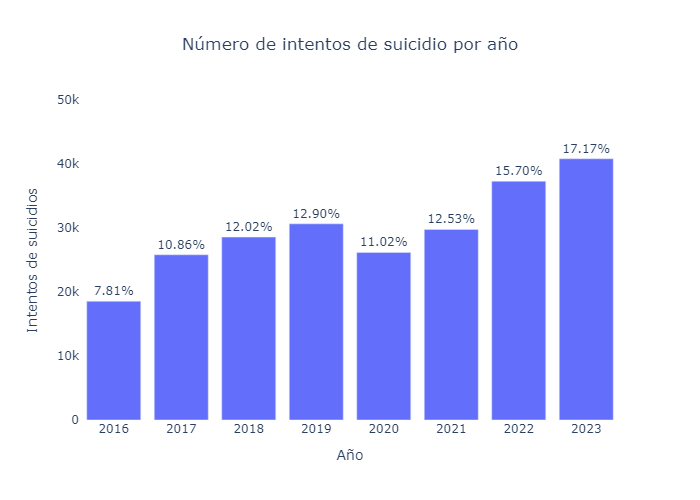

In [49]:
fig = px.bar(
    observaciones_year, 
    x='year', 
    y='conteo',
    title='Número de intentos de suicidio por año',
    labels={'year': 'Año', 'conteo': 'Intentos de suicidios'}
)
fig.update_traces(
    text=observaciones_year['porcentaje'].map('{:.2f}%'.format),
    textposition='outside'
)
fig.update_layout(title_x=0.5,yaxis=dict(range=[0, 50000]),
                  paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(tickmode='linear', dtick=1 )
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

Tanto la tabla como el gráfico de barras sugieren que el número de casos de intento de suicidio ha aumentado de manera constante entre 2016 y 2023. La única excepción a esta tendencia es la disminución observada entre 2020 y 2021, seguida de una reanudación del aumento en los años posteriores.

## Semana Epidemiológica

La variable `week` contiene información sobre la semana epidemiológica en que se reportó cada caso de intento de suicidio. Siguiendo el procedimiento aplicado a otras variables, se construye una tabla de frecuencias para analizar el porcentaje de casos por año. Posteriormente, se elabora un diagrama de barras para visualizar la distribución de los datos:

In [50]:
observaciones_week = df.groupby('week').size().reset_index(name='conteo')
total = observaciones_week['conteo'].sum()
observaciones_week['porcentaje'] = (observaciones_week['conteo'] / total) * 100
observaciones_week['week'] = observaciones_week['week'].astype('category')
observaciones_week.head()

,week,conteo,porcentaje
0,1,3403,1.431727
1,2,3275,1.377874
2,3,3445,1.449397
3,4,3589,1.509982
4,5,4039,1.699308


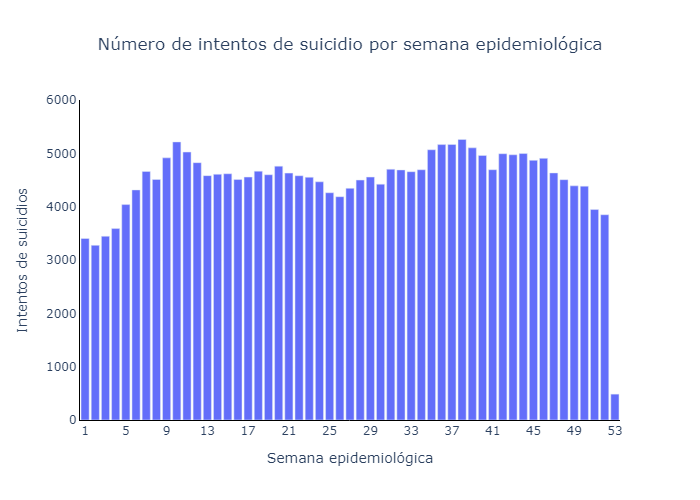

In [51]:
fig = px.bar(observaciones_week, x='week', y='conteo',
    title='Número de intentos de suicidio por semana epidemiológica',
    labels={'week': 'Semana epidemiológica', 'conteo': 'Intentos de suicidios'}
)

fig.update_traces(
    hovertemplate='%{x}: %{y}<br>Porcentaje: %{customdata:.2f}%<extra></extra>',
    customdata=observaciones_week[['porcentaje']]
)

fig.update_layout(title_x=0.5,
    yaxis=dict(range=[0, 6000]), paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)'
)
tick_vals = np.arange(1, len(observaciones_week['week']) + 1, 4)
fig.update_xaxes(showline=True,linecolor='black',tickvals=tick_vals, tickangle=0)
fig.update_yaxes(showline=True, linecolor='black',gridcolor='white')
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

El gráfico de barras y la tabla de frecuencias indican que los reportes de casos de intento de suicidio muestran pequeños incrementos entre las semanas 1 y 10, así como en la semana 38. También se observa una reducción abrupta en la última semana epidemiológica del año. Sin embargo, en general, el número de reportes se mantiene constante a lo largo del año. Para analizar con mayor profundidad el comportamiento de los casos de intento de suicidio durante el año, en la próxima sección se mensualizarán las observaciones.

## Mes

Como se mencionó en la sección anterior, procederemos a mensualizar las observaciones y a construir una tabla de frecuencias para analizar el número de casos a lo largo del año:

In [52]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
meses_espanol = {1: 'enero', 2: 'febrero', 3: 'marzo', 4: 'abril', 5: 'mayo', 6: 'junio',
                 7: 'julio', 8: 'agosto', 9: 'septiembre', 10: 'octubre', 11: 'noviembre', 12: 'diciembre'}
df['month'] = df['month'].map(meses_espanol)
print(df[['date', 'month']].head())

        date  month
0 2016-06-09  junio
1 2016-05-28   mayo
2 2016-05-23   mayo
3 2016-05-25   mayo
4 2016-05-27   mayo


In [53]:
observaciones_month = df.groupby('month').size().reset_index(name='conteo')
total = observaciones_month['conteo'].sum()
observaciones_month['porcentaje'] = (observaciones_month['conteo'] / total) * 100
observaciones_month['month'] = observaciones_month['month'].astype('category')
orden_meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
               'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
observaciones_month['month'] = pd.Categorical(observaciones_month['month'], categories=orden_meses, ordered=True)
observaciones_month = observaciones_month.sort_values('month')
observaciones_month

,month,conteo,porcentaje
3,enero,15379,6.470328
4,febrero,17849,7.509519
7,marzo,21648,9.107853
0,abril,19596,8.244525
8,mayo,20593,8.663988
6,junio,18799,7.909208
5,julio,19537,8.219703
1,agosto,20999,8.834802
11,septiembre,22211,9.344721
10,octubre,21946,9.233229


La tabla de frecuencias muestra que el número de observaciones aumenta de enero a marzo, lo que coincide con las tendencias observadas en las semanas epidemiológicas. Además, se observa una ligera disminución en el número de casos en diciembre, aunque no es tan abrupta como la reducción encontrada en la sección anterior. Finalizaremos el análisis de esta variable con un diagrama de barras que facilitará la visualización del número de casos de intentos de suicidio a lo largo del año:

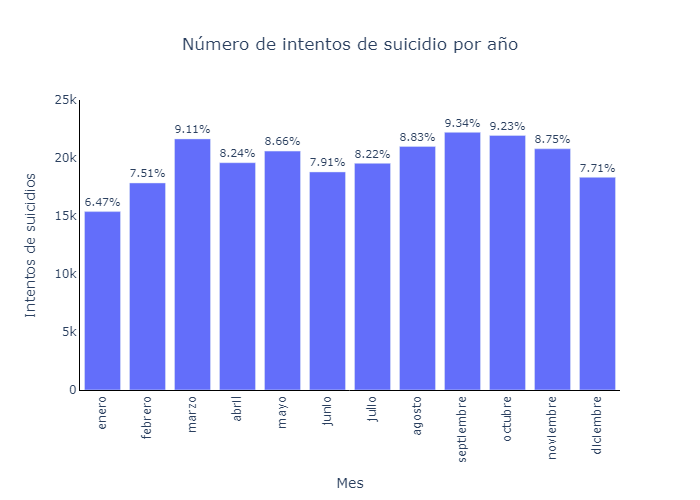

In [54]:
fig = px.bar(observaciones_month, x='month', y='conteo',
    title='Número de intentos de suicidio por año',
    labels={'month': 'Mes', 'conteo': 'Intentos de suicidios'})
fig.update_traces(text=observaciones_month['porcentaje'].map('{:.2f}%'.format),
    textposition='outside')
fig.update_layout(title_x=0.5, yaxis=dict(range=[0, 25000]), paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(tickmode='linear', dtick=1, tickangle= -90)
fig.update_yaxes(showline=True, linecolor='black', gridcolor='white')
fig.update_xaxes(showline=True, linecolor='black', gridcolor='white')
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# Mapa

Para realizar un análisis más detallado de la distribución de los casos de intento de suicidio reportados en Colombia entre 2016 y 2023, se construirá un mapa interactivo utilizando la biblioteca de `folium`. Dado que el proceso de creación de mapas interactivos ha sido abordado en documentos anteriores, en esta sección nos enfocaremos en presentar los resultados principales:

In [86]:
mapa_ant = gpd.read_file("C:/Users/jcami/OneDrive/Escritorio/DATAVIZ/Departamentos_Junio_2024_shp/Departamentos_Junio_2024_shp/Departamento.shp")
mapa_ant['geometry'] = mapa_ant['geometry'].apply(lambda geom: make_valid(geom))

In [87]:
df['department'] = df['department'].replace({
    'bogota': 'Cundinamarca',
    'antioquia': 'Antioquia',
    'magdalena': 'Magdalena',
    'santander': 'Santander',
    'tolima': 'Tolima',
    'vaupes': 'Vaupés',
    'narino': 'Nariño',
    'cordoba': 'Córdoba',
    'bolivar': 'Bolívar',
    'valle': 'Valle del Cauca',
    'atlantico': 'Atlántico',
    'cundinamarca': 'Cundinamarca',
    'norte santander': 'Norte de Santander',
    'risaralda': 'Risaralda',
    'putumayo': 'Putumayo',
    'arauca': 'Arauca',
    'amazonas': 'Amazonas',
    'boyaca': 'Boyacá',
    'huila': 'Huila',
    'guajira': 'La Guajira',
    'caldas': 'Caldas',
    'caqueta': 'Caquetá',
    'cauca': 'Cauca',
    'sucre': 'Sucre',
    'quindio': 'Quindío',
    'meta': 'Meta',
    'cesar': 'Cesar',
    'casanare': 'Casanare',
    'vichada': 'Vichada',
    'choco': 'Chocó',
    'guaviare': 'Guaviare',
    'guainia': 'Guainía',
    'san andres': 'San andres islas'
})

mapa_ant['DeNombre'] = mapa_ant['DeNombre'].replace({
    'San Andrés Providencia y Santa Catalina': 'San andres islas',
    'Area en Litigio Cauca - Huila': 'Huila',
})

In [88]:
df["codigo"] = df['department']
mapa_ant["codigo"] = mapa_ant['DeNombre']

In [89]:
df_mapa = df[~df.index.isin([57783,65839,68774])]
observaciones_codigo_year = df_mapa.groupby(['codigo']).size().reset_index(name='conteo')
Datos_tot = pd.merge(observaciones_codigo_year, mapa_ant, on='codigo', how='outer')
gdf = gpd.GeoDataFrame(Datos_tot, geometry='geometry')

In [98]:
def create_map_with_hover(gdf):
    m = folium.Map(location=[4.5709, -74.2973], zoom_start=4.4,
                   tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',  # No usar capa de tiles inicial
                   attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.',
                   scrollWheelZoom=True,  # Deshabilitar zoom con scroll
                   dragging=True,
                   zoomControl=True)
    
    choropleth = Choropleth(
        geo_data=gdf,
        name='Choropleth',
        data=gdf,
        columns=['codigo', 'conteo'],
        key_on='feature.properties.codigo',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Conteo'
    ).add_to(m)

    # Añadir la funcionalidad de hover
    GeoJson(
        gdf,
        style_function=lambda feature: {
            'fillColor': '#ffffff00',
            'color': 'black',
            'weight': 0.5
        },
        tooltip=GeoJsonTooltip(
            fields=['codigo', 'conteo'],
            aliases=['Departamento: ', 'Casos: '],
            localize=True
        )
    ).add_to(m)

    # Ajustar CSS para ocultar la leyenda y la atribución, pero dejar el hover visible
    m.get_root().html.add_child(folium.Element("""
    <style>
        .leaflet-control-attribution {
            display: none; /* Ocultar la atribución */
        }
        .leaflet-control-attribution + .leaflet-control-container {
            display: none !important; /* Ocultar el contenedor de atribución */
        }
        .leaflet-tooltip {
            font-size: 12px; /* Ajustar el tamaño del texto del hover si es necesario */
        }
        .leaflet-container {
            height: 800px; /* Ajustar altura del mapa */
            width: 100%;  /* Ajustar ancho del mapa */
            margin-bottom: 0px; /* Eliminar margen inferior */
        }
    </style>
    """))

    return m

In [99]:
create_map_with_hover(gdf).save('Mapa_suicidios.html')

Tal como han sugerido analisis anteriores ([descargar el mapa interactivo](https://uninortemy.sharepoint.com/:u:/g/personal/cjarango_uninorte_edu_co/EX0jJtqrNLhKmVIVMm0EZuoBjb4_h6fSofKfOxTNW-5P1g?e=vHGjMR)), los departamentos con el mayor número de reportes de intentos de suicidio fueron Antioquia y Cundinamarca, con 38,642 y 43,363 casos, respectivamente. Otros departamentos del interior del país, como Valle del Cauca, Tolima, Caldas y Risaralda, también muestran una alta incidencia de intentos de suicidio entre 2016 y 2023. En contraste, los departamentos del sur del país, como Vaupés y Guaviare, reportaron el menor número de intentos de suicidio durante el mismo período.

# Serie temporal

En esta sección, analizaremos detalladamente la serie temporal derivada de la variable `date`. Comenzaremos por mensualizar las observaciones para reducir el ruido y resaltar las tendencias:

In [82]:
pd.options.mode.chained_assignment = None 
df2 = df.loc[:, ['date']].copy() 
observaciones_por_fecha = df2[df2['date'] < '2024-01-01']
observaciones_por_fecha['date'] = pd.to_datetime(observaciones_por_fecha['date'])
observaciones_por_fecha['date'] = observaciones_por_fecha['date'] + pd.offsets.MonthEnd(0)
observaciones_por_fecha = observaciones_por_fecha.groupby('date').size().reset_index(name='conteo')
observaciones_por_fecha.describe()

,date,conteo
count,96,96.000000
mean,2020-01-14 21:30:00,2473.072917
min,2016-01-31 00:00:00,507.000000
25%,2018-01-23 06:00:00,2014.750000
50%,2020-01-15 12:00:00,2449.000000
75%,2022-01-07 18:00:00,2810.000000
max,2023-12-31 00:00:00,3878.000000
std,NaN,640.429597


La descripción de los datos revela que, en promedio, se reportan aproximadamente 2,449 casos de intentos de suicidio por mes (desviación estándar = 640.43), con un mínimo de 507 casos y un máximo de 3,878 casos. A continuación, procederemos a graficar el número de intentos de suicidio en Colombia entre 2016 y 2023:

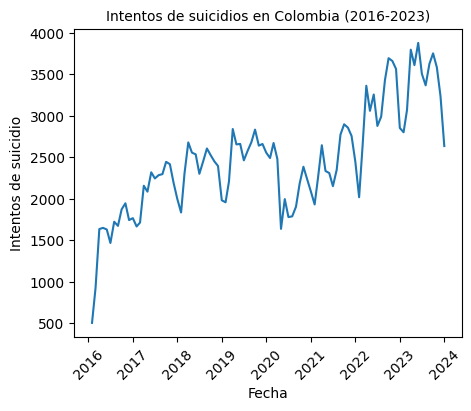

In [51]:
plt.figure(figsize=(5, 4))
sns.lineplot(x='date', y='conteo', data=observaciones_por_fecha, marker='')
plt.xlabel('Fecha', fontsize=10)
plt.ylabel('Intentos de suicidio', fontsize=10)
plt.title('Intentos de suicidios en Colombia (2016-2023)', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)
plt.show()

La gráfica indica un aumento constante en el número de intentos de suicidio durante los últimos siete años, alcanzando su punto más alto en la primera mitad de 2023. A continuación, procederemos a visualizar el número de intentos de suicidio en el mismo período, diferenciando entre sexos para una mayor comprensión de las tendencias.

In [85]:
df3 = df.loc[:, ['date', 'sex']].copy()
observaciones_por_sex = df3[df3['date'] < '2024-01-01']
observaciones_por_sex['date'] = pd.to_datetime(observaciones_por_sex['date'])
observaciones_por_sex['date'] = observaciones_por_sex['date'] + pd.offsets.MonthEnd(0)
observaciones_por_sex = observaciones_por_sex.groupby(['date', 'sex']).size().reset_index(name='conteo')
observaciones_por_sex.groupby('sex')['conteo'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
femenino,96.0,1576.385417,443.255976,309.0,1243.25,1554.5,1777.25,2566.0
masculino,96.0,896.687500,202.074364,198.0,785.75,890.5,989.50,1312.0


Los estadísticos descriptivos revelan que, en promedio, se reportan aproximadamente 1,777 casos de intentos de suicidio mensuales en mujeres, mientras que en hombres el promedio es de 890 casos mensuales. A continuación, procederemos a graficar ambas series temporales para visualizar de manera clara las diferencias entre los grupos:

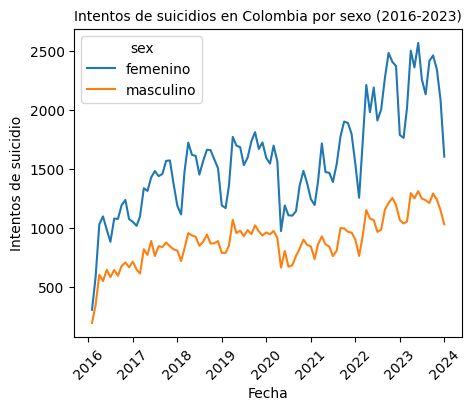

In [53]:
plt.figure(figsize=(5, 4))
sns.lineplot(x='date', y='conteo', hue='sex', data=observaciones_por_sex, marker='')
plt.xlabel('Fecha', fontsize=10)
plt.ylabel('Intentos de suicidio', fontsize=10)
plt.title('Intentos de suicidios en Colombia por sexo (2016-2023)', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)
plt.show()

Al igual que en la gráfica general, el diagrama muestra que el número de reportes relacionados con intentos de suicidio ha aumentado de manera constante en los últimos siete años. No obstante, se observa que el crecimiento ha sido más pronunciado en mujeres que en hombres, con una marcada diferencia al final de 2023. Con esta información, ahora volveremos a analizar los casos de suicidio en la población general para estudiar la autocorrelación de los rezagos, considerando 84 rezagos, correspondientes a cada mes entre 2016 y 2023:

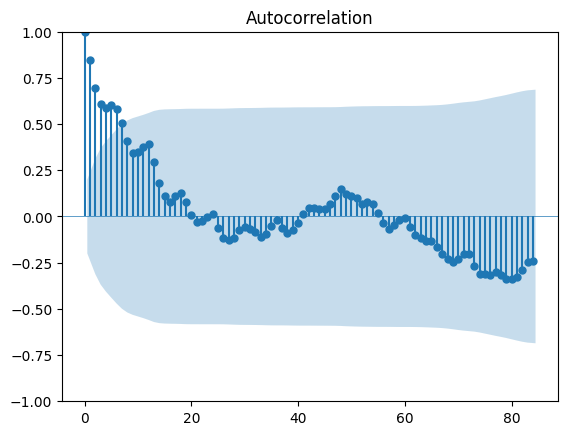

In [35]:
plot_acf(observaciones_por_fecha['conteo'], lags=84, linewidth=0.5)
plt.show()

El gráfico muestra que los primeros ocho rezagos están fuera de los intervalos de confianza, lo que indica una posible ausencia de estacionalidad en la serie temporal. Además, se observa que los rezagos pueden presentar una tendencia estacional, ya que el valor de los rezagos cambia de positivo a negativo aproximadamente cada veinte rezagos. Para complementar el análisis de la serie, procederemos a examinar la autocorrelación parcial de los rezagos:

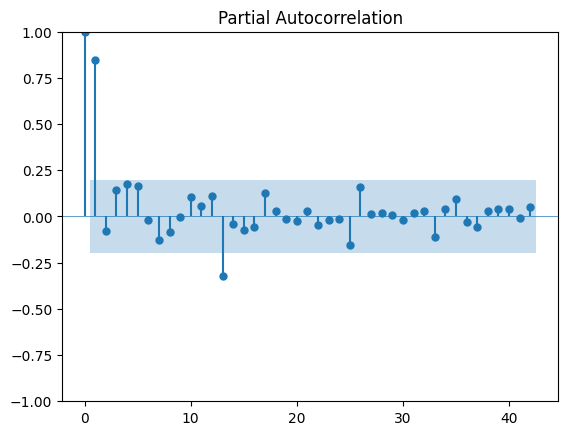

In [36]:
plot_pacf(observaciones_por_fecha['conteo'], lags=42, linewidth=0.5)
plt.show()

El gráfico indica una fuerte autocorrelación en los rezagos. Además, se observa que uno de los rezagos presenta un valor negativo, lo que sugiere una disminución abrupta en el número de casos de intentos de suicidio, probablemente a principios de 2020. A continuación, procederemos a comprobar la estacionalidad de la serie utilizando la prueba de Dickey-Fuller aumentada:

In [37]:
adf_result = adfuller(observaciones_por_fecha['conteo'].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -1.231172
p-value: 0.660045


Como sugería el gráfico de correlación parcial, la prueba de Dickey-Fuller confirma que la serie no presenta un comportamiento estacional. Debido a esto, procederemos a descomponer la serie temporal y, en consecuencia, a hacerla estacionaria utilizando la función `seasonal_decompose` de la librería `statsmodels`:

In [62]:
decompose_model = seasonal.seasonal_decompose(observaciones_por_fecha['conteo'].tolist(),
period=24, model='additive')

Text(0.5, 1.0, 'Variaciones irregulares de los intentos de suicidios')

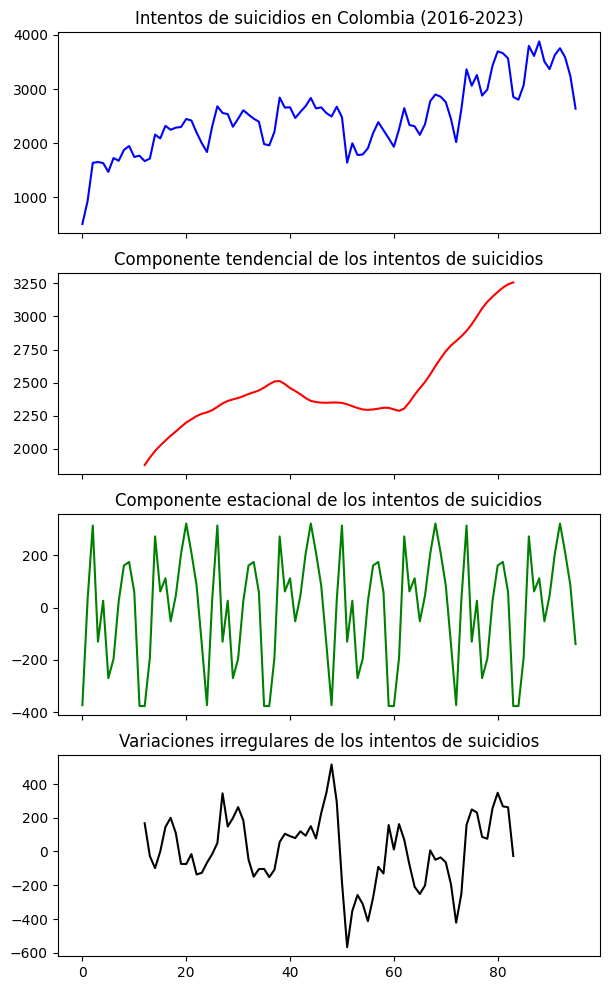

In [63]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(7, 12)

observaciones_por_fecha['conteo'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Intentos de suicidios en Colombia (2016-2023)')

pd.Series(data=decompose_model.trend, index=observaciones_por_fecha.index).plot(color='r',
linestyle='-', ax=axarr[1])
axarr[1].set_title('Componente tendencial de los intentos de suicidios')

pd.Series(data=decompose_model.seasonal, index=observaciones_por_fecha.index).plot(color='g',
linestyle='-', ax=axarr[2])
axarr[2].set_title('Componente estacional de los intentos de suicidios')

pd.Series(data=decompose_model.resid, index=observaciones_por_fecha.index).plot(color='k',
linestyle='-', ax=axarr[3])
axarr[3].set_title('Variaciones irregulares de los intentos de suicidios')

In [64]:
stattools.adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]],autolag='AIC')
print('El p-valor de la prueba ADF sobre variaciones irregulares es: ', adf_result[1])

El p-valor de la prueba ADF sobre variaciones irregulares es:  0.6600447244240355


La prueba de Dickey-Fuller indica que las variaciones irregulares en la serie no son estacionarias. Por lo tanto, en futuros análisis, se deberán considerar técnicas de transformación, como la diferenciación, o el uso de modelos que no requieran estacionariedad para modelar adecuadamente los datos. Para completar el análisis, procederemos a examinar la normalidad de las variaciones irregulares.

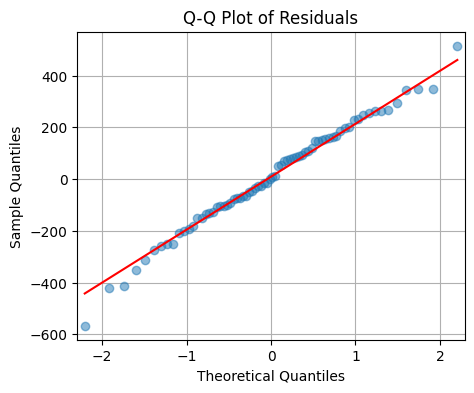

In [68]:
decompose_model = seasonal.seasonal_decompose(observaciones_por_fecha['conteo'], period=24, model='additive')
plt.rcParams.update({'figure.figsize': (5, 4)})
fig = sm.qqplot(decompose_model.resid.dropna(), line='s', alpha=0.5, lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

El gráfico cuantil-cuantil indica que las variaciones irregulares parecen aproximarse a una distribución gaussiana. Para corroborar esta observación, se llevará a cabo la prueba de Shapiro-Wilk y la prueba de Anderson-Darling:

In [81]:
resid_clean = decompose_model.resid.replace([np.inf, -np.inf], np.nan).dropna()
stat, p = shapiro(resid_clean)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.992, p=0.925
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [80]:
anderson_test = anderson(resid_clean, dist='norm')
stat = anderson_test.statistic
critical_values = anderson_test.critical_values
print('Statistics=%.3f' % (stat))
if stat < critical_values[2]:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.201
La muestra se aproxima de una distribución gaussiana (no se rechaza H0)


Como lo sugería el gráfico cuantil-cuantil, ambas pruebas de normalidad confirman que las variaciones irregulares de la serie se ajustan a una distribución normal.